In [2]:
import pandas as pd
data = pd.read_csv("./preprocessed_data.csv")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
X = data.drop("project_is_approved",axis=1)
y = data['project_is_approved'].values

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(73196, 8) (73196,)
(36052, 8) (36052,)


In [6]:
import pickle
with open('./glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000,stop_words = 'english')
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted TFIDF to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
# print(X_train_essay_bow.shape, y_train.shape)
# print(X_test_essay_bow.shape, y_test.shape)


After vectorizations


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
#school state
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

In [9]:
#teacher prefix
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)

X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

In [10]:
#project grade catagory
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)

X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

In [11]:
#Normalizing Price Data
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))

X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

In [12]:
#clean subcatagories
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcat_ohe = vectorizer.transform(X_train['clean_subcategories'].values)

X_test_subcat_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

In [13]:
#clean catagories
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cat_ohe = vectorizer.transform(X_train['clean_categories'].values)

X_test_cat_ohe = vectorizer.transform(X_test['clean_categories'].values) 

In [14]:
#teacher_number_of_previously_posted_projects
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_prev_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_test_prev_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [15]:
#sentiment scores
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sentiment_scores = []
for sentence in tqdm(X_train['essay'].values):
  dic = sid.polarity_scores(sentence)
  comp = dic['compound']
  neg = dic['neg']
  neu = dic['neu']
  pos = dic['pos']
  sentiment_scores.append([comp,neg,neu,pos])


100%|██████████| 73196/73196 [01:36<00:00, 755.91it/s]


In [17]:
sentiment_score_test = []
for sentence in tqdm(X_test['essay'].values):
  dic = sid.polarity_scores(sentence)
  comp = dic['compound']
  neg = dic['neg']
  neu = dic['neu']
  pos = dic['pos']
  sentiment_score_test.append([comp,neg,neu,pos])


100%|██████████| 36052/36052 [00:48<00:00, 747.18it/s]


In [18]:
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm,X_train_cat_ohe, X_train_subcat_ohe,X_train_prev_norm,sentiment_scores)).tocsr()

X_te = hstack((X_test_essay_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm,X_test_cat_ohe ,X_test_subcat_ohe,X_test_prev_norm,sentiment_score_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)

print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 5105) (73196,)
(36052, 5105) (36052,)


# **Applying Decision Tree on TFIDF vectors**

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
model = DecisionTreeClassifier()
params = {'max_depth':[1,5,10,50],'min_samples_split':[5,10,100,500]}
grid_search = GridSearchCV(model,params,'roc_auc',return_train_score=True,n_jobs=-1)
grid_search.fit(X_tr,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [20]:
grid_search.best_params_

{'max_depth': 10, 'min_samples_split': 500}

In [21]:
grid_search.cv_results_

{'mean_fit_time': array([  3.02192659,   3.01762156,   2.93630977,   3.01146278,
         11.21259174,  10.77834077,  10.54087234,  10.36731019,
         23.82089972,  23.48445754,  20.74787154,  20.34280658,
        128.99043055, 123.85171819, 110.16431665,  60.3674942 ]),
 'std_fit_time': array([ 0.08895314,  0.09909067,  0.10191378,  0.14804815,  0.20747553,
         0.23107005,  0.12694266,  0.23970692,  0.83859734,  0.73805419,
         0.63318329,  0.65866915,  1.81000586,  2.7372252 ,  5.04366756,
        21.99559612]),
 'mean_score_time': array([0.04412222, 0.0651628 , 0.0453548 , 0.04153142, 0.04787974,
        0.03600855, 0.03084316, 0.03072219, 0.03575544, 0.03488526,
        0.03290706, 0.03128343, 0.02160435, 0.02493353, 0.02545123,
        0.01940184]),
 'std_score_time': array([0.01070149, 0.01224197, 0.01287085, 0.01277643, 0.00875033,
        0.0095222 , 0.00594415, 0.00349059, 0.0089681 , 0.00409666,
        0.00372029, 0.0048489 , 0.00402964, 0.00604955, 0.00534279,


In [22]:
import numpy as np

points_for_plot_train = []
points_for_plot_test = []
points_for_plot = []

for param in grid_search.cv_results_['params']:
  max_depth = param['max_depth']
  min_samples_split = param['min_samples_split']
  lis = [max_depth,min_samples_split]
  points_for_plot.append(lis)


mean_test_score = grid_search.cv_results_['mean_test_score']

mean_train_score = grid_search.cv_results_['mean_train_score']

points_for_plot_train = points_for_plot[:]
points_for_plot_test = points_for_plot[:]


i = 0
for point in points_for_plot_train:
  point.append(mean_train_score[i])
  i = i+1


i = 0
for point in points_for_plot_test:
  point.append(mean_test_score[i])
  i = i+1


points_for_plot_train = np.array(points_for_plot_train)
points_for_plot_test = np.array(points_for_plot_test)

In [23]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go

x1 = points_for_plot_train[:,0]
y1 = points_for_plot_train[:,1]
z1 = points_for_plot_train[:,2]

x2 = points_for_plot_test[:,0]
y2 = points_for_plot_test[:,1]
z2 = points_for_plot_test[:,3]

trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='max_depth'),
        yaxis = dict(title='min_sample_split'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
fig.show()
plt.show()

In [24]:
best_model = DecisionTreeClassifier(max_depth = 5, min_samples_split = 500,)
best_model.fit(X_tr,y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=500)

In [70]:
y_train_predicted = best_model.predict_proba(X_tr)
y_test_predicted = best_model.predict_proba(X_te)
y_train_predicted

array([[0.1433138 , 0.8566862 ],
       [0.57894737, 0.42105263],
       [0.1433138 , 0.8566862 ],
       ...,
       [0.1433138 , 0.8566862 ],
       [0.1433138 , 0.8566862 ],
       [0.1433138 , 0.8566862 ]])

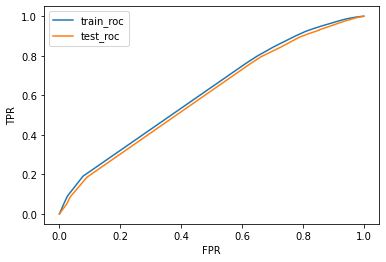

In [71]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_train,y_train_predicted[:,1])
auc_score
#roc on train and test
from sklearn.metrics import roc_curve
train_fpr,train_tpr,_ = roc_curve(y_train,y_train_predicted[:,1])
plt.plot(train_fpr,train_tpr,label='train_roc')
test_fpr,test_tpr,_ = roc_curve(y_test,y_test_predicted[:,1])
plt.plot(test_fpr,test_tpr,label='test_roc')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

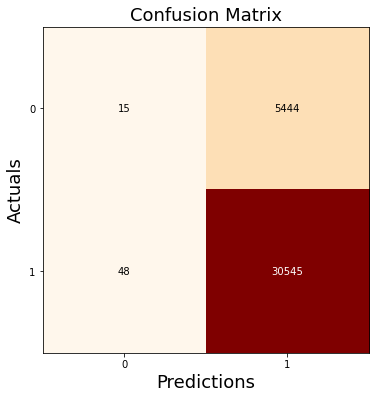

In [72]:
from sklearn.metrics import confusion_matrix
y_test_predicted = best_model.predict(X_te)
confusion_matrix = confusion_matrix(y_test,y_test_predicted)

from mlxtend.plotting import plot_confusion_matrix
 
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, figsize=(6, 6), cmap=plt.cm.OrRd)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

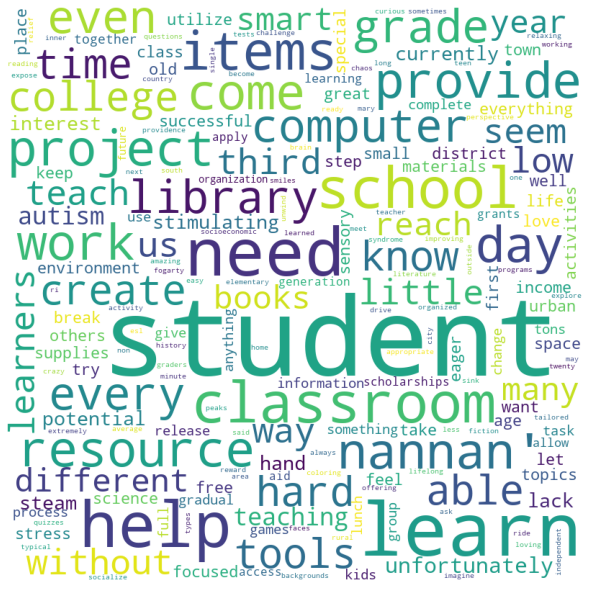

In [73]:
#word cloud
lis_false_pos = []
for p in range(len(y_test_predicted)):
  if (y_test[p]==0)& (y_test_predicted[p] ==1):
    lis_false_pos.append(p)
essays = (X_test["essay"].iloc[lis_false_pos]).values
essays = str(essays)

from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
comment_words = X_test["essay"]
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(essays)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

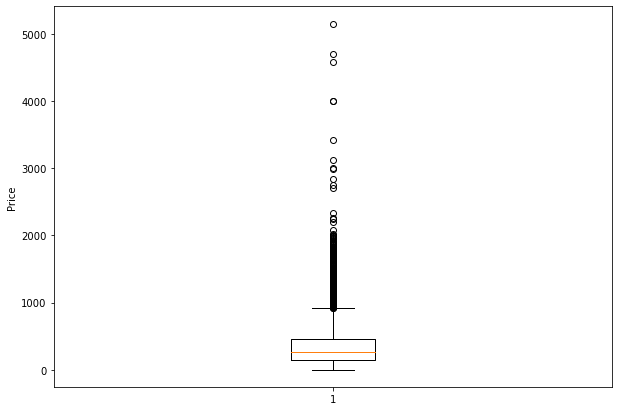

In [78]:
#box plot
prices = (X_test["price"].iloc[lis_false_pos]).values
plt.figure(figsize =(10, 7))
plt.boxplot(prices)
plt.ylabel("Price")
plt.show()

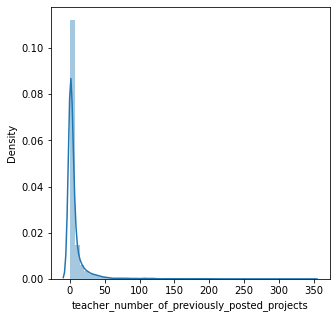

In [81]:
import seaborn as sns
prev = (X_test["teacher_number_of_previously_posted_projects"].iloc[lis_false_pos]).values
plt.figure(figsize =(5, 5))
sns.distplot(prev)
plt.xlabel("teacher_number_of_previously_posted_projects")
plt.show()

# Task 2

***Training model with max_depth = None, basically allowing the model to overfit. Then we extract all non-zero features.***

In [56]:
# Determine all non-zero features 
model = DecisionTreeClassifier(max_depth=None)
model.fit(X_tr,y_train)

DecisionTreeClassifier()

In [64]:
feature_importances = model.feature_importances_
non_zero_features = (feature_importances).nonzero()
X_tr_non_zero_features = X_tr[:,non_zero_features[0]]

In [65]:
#training model with non_zero features
model = DecisionTreeClassifier()
grid_search = GridSearchCV(model,params,'roc_auc',return_train_score=True,n_jobs=-1)
grid_search.fit(X_tr_non_zero_features,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [67]:
grid_search.best_score_ #0.6254656059922232 not much improvement in roc_auc score. Model is performing the same without the 0 weight parameters 

0.6254656059922232

In [68]:
grid_search.best_params_

{'max_depth': 10, 'min_samples_split': 500}

In [82]:
import numpy as np

points_for_plot_train = []
points_for_plot_test = []
points_for_plot = []

for param in grid_search.cv_results_['params']:
  max_depth = param['max_depth']
  min_samples_split = param['min_samples_split']
  lis = [max_depth,min_samples_split]
  points_for_plot.append(lis)


mean_test_score = grid_search.cv_results_['mean_test_score']

mean_train_score = grid_search.cv_results_['mean_train_score']

points_for_plot_train = points_for_plot[:]
points_for_plot_test = points_for_plot[:]


i = 0
for point in points_for_plot_train:
  point.append(mean_train_score[i])
  i = i+1


i = 0
for point in points_for_plot_test:
  point.append(mean_test_score[i])
  i = i+1


points_for_plot_train = np.array(points_for_plot_train)
points_for_plot_test = np.array(points_for_plot_test)

In [83]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go

x1 = points_for_plot_train[:,0]
y1 = points_for_plot_train[:,1]
z1 = points_for_plot_train[:,2]

x2 = points_for_plot_test[:,0]
y2 = points_for_plot_test[:,1]
z2 = points_for_plot_test[:,3]

trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='max_depth'),
        yaxis = dict(title='min_sample_split'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
fig.show()
plt.show()

In [84]:
best_model = DecisionTreeClassifier(max_depth = 10, min_samples_split = 500)
best_model.fit(X_tr,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=500)

In [85]:
y_train_predicted = best_model.predict_proba(X_tr)
y_test_predicted = best_model.predict_proba(X_te)
y_train_predicted

array([[0.14920595, 0.85079405],
       [0.57894737, 0.42105263],
       [0.14920595, 0.85079405],
       ...,
       [0.10630189, 0.89369811],
       [0.14920595, 0.85079405],
       [0.14920595, 0.85079405]])

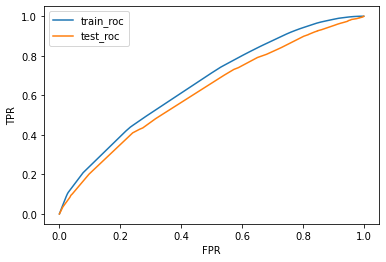

In [86]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_train,y_train_predicted[:,1])
auc_score
#roc on train and test
from sklearn.metrics import roc_curve
train_fpr,train_tpr,_ = roc_curve(y_train,y_train_predicted[:,1])
plt.plot(train_fpr,train_tpr,label='train_roc')
test_fpr,test_tpr,_ = roc_curve(y_test,y_test_predicted[:,1])
plt.plot(test_fpr,test_tpr,label='test_roc')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

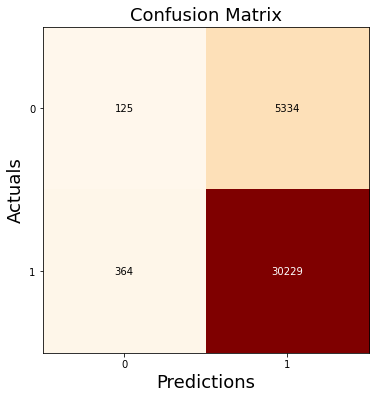

In [87]:
from sklearn.metrics import confusion_matrix
y_test_predicted = best_model.predict(X_te)
confusion_matrix = confusion_matrix(y_test,y_test_predicted)

from mlxtend.plotting import plot_confusion_matrix
 
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, figsize=(6, 6), cmap=plt.cm.OrRd)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

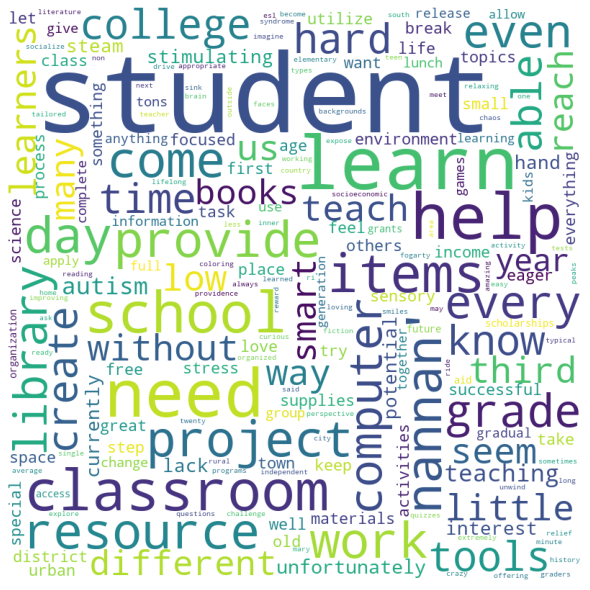

In [88]:
lis_false_pos = []
for p in range(len(y_test_predicted)):
  if (y_test[p]==0)& (y_test_predicted[p] ==1):
    lis_false_pos.append(p)
essays = (X_test["essay"].iloc[lis_false_pos]).values
essays = str(essays)

from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
comment_words = X_test["essay"]
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(essays)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

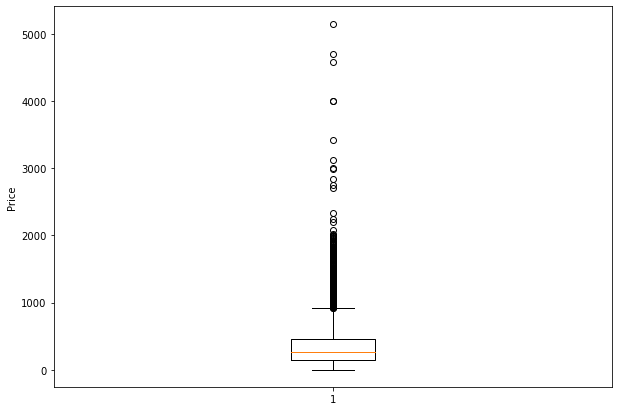

In [89]:
#box plot
prices = (X_test["price"].iloc[lis_false_pos]).values
plt.figure(figsize =(10, 7))
plt.boxplot(prices)
plt.ylabel("Price")
plt.show()

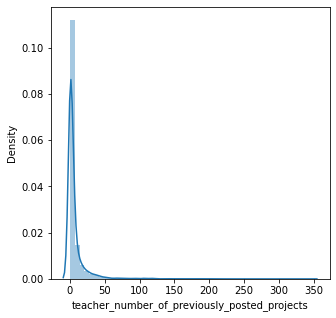

In [90]:
import seaborn as sns
prev = (X_test["teacher_number_of_previously_posted_projects"].iloc[lis_false_pos]).values
plt.figure(figsize =(5, 5))
sns.distplot(prev)
plt.xlabel("teacher_number_of_previously_posted_projects")
plt.show()

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter", "Auc"]
x.add_row(["TFIDF-W2V","Decision Tree",grid_search.best_params_,str(grid_search.best_score_)])
print(x)